<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Removing repo
Cloning repo


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import clone
from sklearn.model_selection import StratifiedShuffleSplit

from active_learning_ratio_estimation.dataset import UnparameterizedRatioDataset
from active_learning_ratio_estimation.util import ideal_classifier_probs_from_simulator, negative_log_likelihood_ratio
from active_learning_ratio_estimation.model import UnparameterizedRatioModel, DenseClassifier, FlipoutClassifier
from active_learning_ratio_estimation.model.validation import get_calibration_metrics 

tfd = tfp.distributions


np.random.seed(0)
tf.random.set_seed(0)

In [0]:
# matplotlib setup

%matplotlib inline

size=24
params = {
    'legend.fontsize': size*0.75,
    'figure.figsize': (10, 5),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'font.family': 'sans-serif',
    'axes.titlepad': 12.5
}
plt.rcParams.update(params)

In [0]:
def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

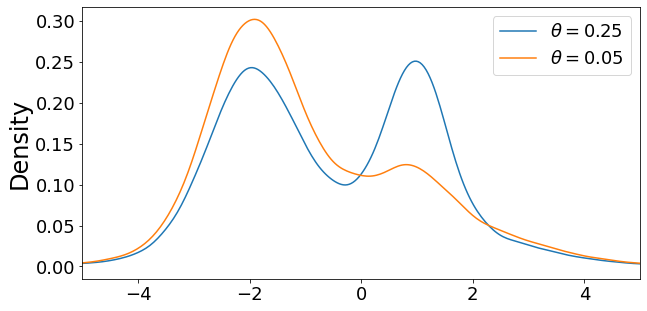

In [5]:
theta_0 = 0.25
theta_1 = 0.05
n_samples_per_theta = int(1e5)


def create_dataset():
    ds = UnparameterizedRatioDataset.from_simulator(
        n_samples_per_theta=n_samples_per_theta,
        simulator_func=triple_mixture,
        theta_0=theta_0,
        theta_1=theta_1
    )
    return ds


ds = create_dataset()

# plot distributions of the data
ax = pd.DataFrame({
    fr'$\theta = {theta_0}$': ds[ds.y==0].x.squeeze(),
    fr'$\theta = {theta_1}$': ds[ds.y==1].x.squeeze(),
}).plot.kde(xlim=(-5, 5))
ax.set_xlabel('$x$')
ax.set_title(r'$p(x|\theta$')

In [0]:
def create_models(verbose=2):
    # hyperparams
    epochs = 10
    patience = 2
    validation_split = 0.1
    n_hidden = (10, 10)

    # regular, uncalibrated model
    regular_estimator = DenseClassifier(n_hidden=n_hidden, activation='tanh',
                                        epochs=epochs, patience=patience,
                                        validation_split=validation_split, verbose=verbose)
    regular_uncalibrated = UnparameterizedRatioModel(estimator=regular_estimator, calibration_method=None,
                                                     normalize_input=False)

    # bayesian, uncalibrated model
    bayesian_estimator = FlipoutClassifier(n_hidden=n_hidden, activation='relu',
                                           epochs=epochs, patience=patience,
                                           validation_split=validation_split, verbose=verbose)
    bayesian_uncalibrated = UnparameterizedRatioModel(estimator=bayesian_estimator, calibration_method=None,
                                                      normalize_input=False)

    # regular, calibrated model
    cv = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
    regular_calibrated = UnparameterizedRatioModel(estimator=clone(regular_estimator), calibration_method='sigmoid',
                                                   normalize_input=False, cv=cv)

    models = {
        'Regular Uncalibrated': regular_uncalibrated,
        'Bayesian Uncalibrated': bayesian_uncalibrated,
        'Regular Calibrated': regular_calibrated
    }
    return models


models = create_models()

In [7]:
quantities = ('y_pred', 'nllr')


def fit_predict_models(models, x, dataset, verbose=True):
    columns = pd.MultiIndex.from_product([quantities, models])
    results = pd.DataFrame(columns=columns, index=x)

    for model_name, model in models.items():
        if verbose:
            print(f'\n******* Fitting {model_name} *******\n')
        model.fit(dataset)
        results['y_pred', model_name] = model.predict_proba(x)[:, 1]
        results['nllr', model_name] = model.predict_negative_log_likelihood_ratio(x)

    results['y_pred', 'Ideal'] = ideal_classifier_probs_from_simulator(x, triple_mixture, theta_0, theta_1)
    results['nllr', 'Ideal'] = negative_log_likelihood_ratio(x, triple_mixture, theta_0, theta_1)

    return results 


x = np.linspace(-5, 5, int(1e4))
results = fit_predict_models(models, x, ds)


******* Fitting Regular Uncalibrated *******

Epoch 1/10
5625/5625 - 9s - loss: 0.6795 - accuracy: 0.5718 - val_loss: 0.6753 - val_accuracy: 0.5775
Epoch 2/10
5625/5625 - 8s - loss: 0.6778 - accuracy: 0.5760 - val_loss: 0.6751 - val_accuracy: 0.5788
Epoch 3/10
5625/5625 - 7s - loss: 0.6776 - accuracy: 0.5762 - val_loss: 0.6750 - val_accuracy: 0.5798
Epoch 4/10
5625/5625 - 8s - loss: 0.6776 - accuracy: 0.5767 - val_loss: 0.6750 - val_accuracy: 0.5796
Epoch 5/10
5625/5625 - 8s - loss: 0.6775 - accuracy: 0.5768 - val_loss: 0.6756 - val_accuracy: 0.5784

******* Fitting Bayesian Uncalibrated *******

Epoch 1/10
Instructions for updating:
Please use `layer.add_weight` method instead.
5625/5625 - 10s - loss: 0.6824 - accuracy: 0.5682 - val_loss: 0.6779 - val_accuracy: 0.5786
Epoch 2/10
5625/5625 - 10s - loss: 0.6792 - accuracy: 0.5761 - val_loss: 0.6768 - val_accuracy: 0.5789
Epoch 3/10
5625/5625 - 10s - loss: 0.6790 - accuracy: 0.5762 - val_loss: 0.6768 - val_accuracy: 0.5778
Epoch 4/10
56

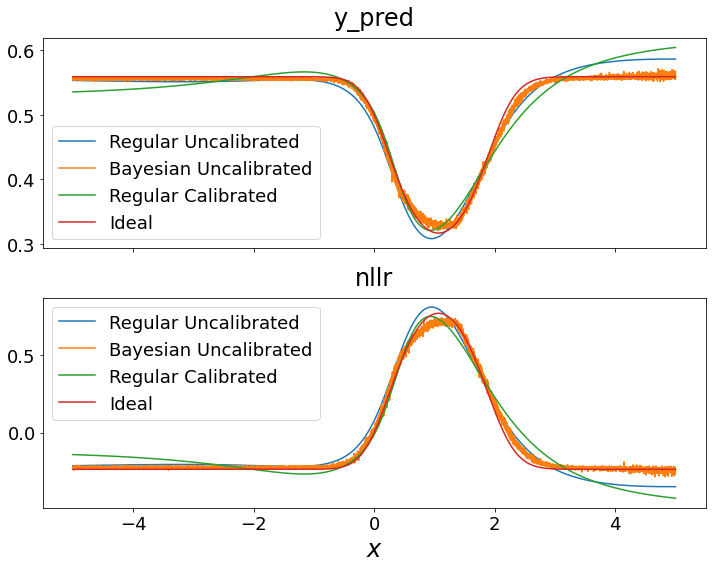

In [8]:
fig, axarr = plt.subplots(2, figsize=(10, 8), sharex=True)

for ax, quantity in zip(axarr, quantities):
    results[quantity].plot(ax=ax, title=quantity)

axarr[1].set_xlabel('$x$')
fig.tight_layout()
fig.show()

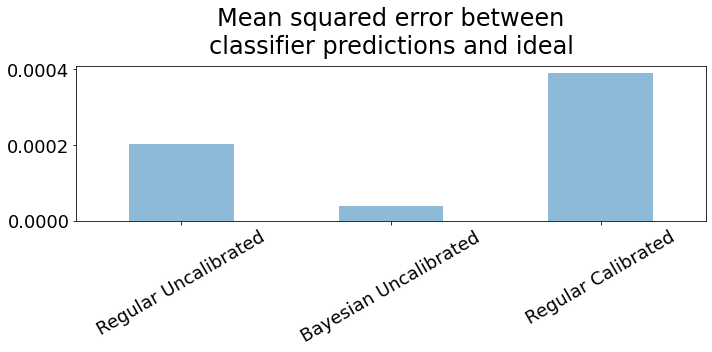

In [9]:
def calculate_mse(results):
    mses = pd.Series(dtype=float)
    y_preds = results['y_pred']

    for model_name in y_preds.columns:
        if model_name == 'Ideal':
            continue
        mses[model_name] = np.mean((y_preds[model_name] - y_preds['Ideal']) ** 2)

    return mses


mses = calculate_mse(results)
fig, ax = plt.subplots()
mses.plot.bar(ax=ax, rot=30, alpha=0.5)
ax.set_title('Mean squared error between\nclassifier predictions and ideal')
fig.tight_layout()
fig.show()

In [0]:
# plot calibration curves and scores
calibration_curves, scores = get_calibration_metrics(ratio_models=models, dataset=ds, n_data=int(1e4), n_bins=20)

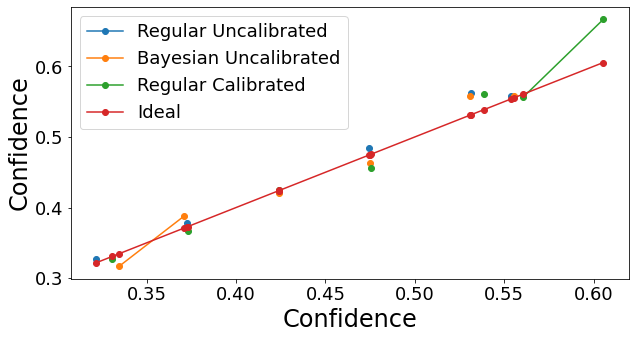

In [11]:
ax = calibration_curves.plot(marker='o')
ax.set_ylabel('Confidence')
plt.show()

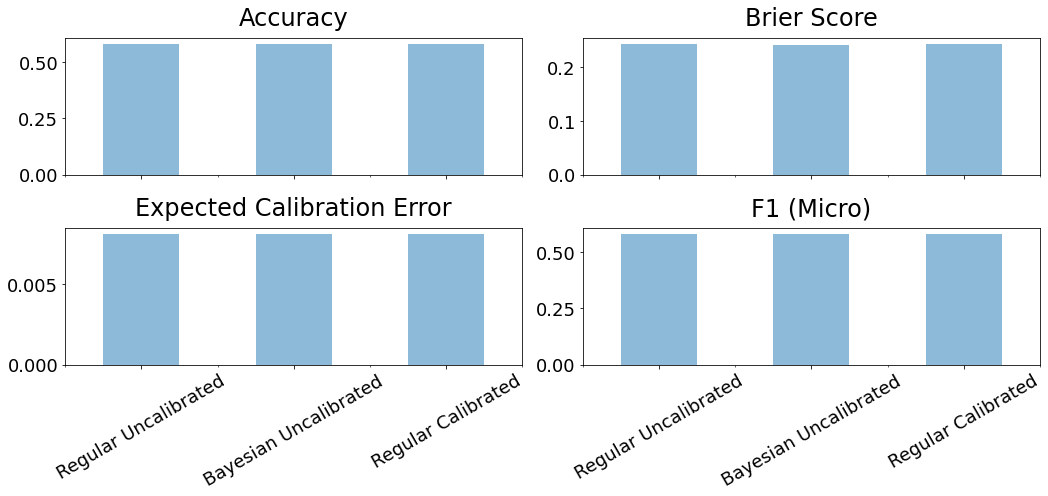

In [12]:
score_names = scores.index.levels[0]
f, axarr = plt.subplots(2, 2, sharex=True, figsize=(15, 7))

for ax, score_name in zip(np.ravel(axarr), score_names):
    scores[score_name].plot.bar(ax=ax, alpha=0.5, rot=30, title=score_name)

f.tight_layout()
f.show()

In [13]:
# Repeat the process, and find the MSE with error bars
n_repeats = 9
all_mses = [mses]
all_scores = [scores]

for i in range(n_repeats):
    ds = create_dataset()
    models = create_models(verbose=False)
    print(f'Refitting models {i+1}/{n_repeats}')
    results = fit_predict_models(models, x, ds, verbose=False)
    all_mses.append(calculate_mse(results))
    _, scores = get_calibration_metrics(ratio_models=models, dataset=ds, n_data=int(1e4), n_bins=20)
    all_scores.append(scores)

Refitting models 1/9
Refitting models 2/9
Refitting models 3/9
Refitting models 4/9
Refitting models 5/9
Refitting models 6/9
Refitting models 7/9
Refitting models 8/9
Refitting models 9/9


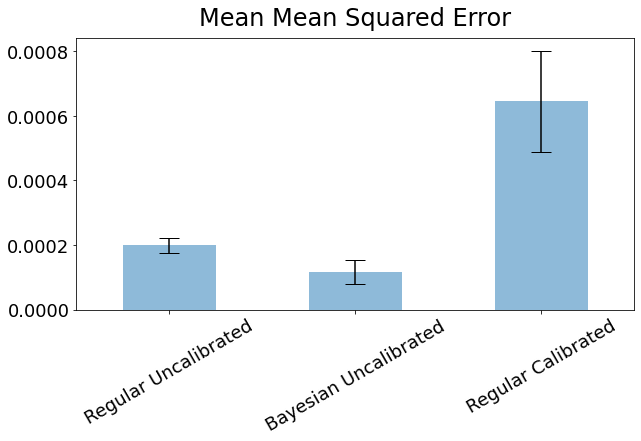

In [14]:
def plot_bar_chart_with_errors(all_dfs, ax=None, title=None):
    n = len(all_dfs)
    mean = sum(all_dfs)/n
    variance  = sum([(df-mean)**2 for df in all_dfs])/(n-1)
    std = variance**0.5
    stderr = std/np.sqrt(n)
    ax = mean.plot.bar(
        ax=ax,
        yerr=stderr,
        alpha=0.5,
        capsize=10,
        rot=30,
        title=title
    )
    return ax

ax = plot_bar_chart_with_errors(all_mses, title='Mean Mean Squared Error')

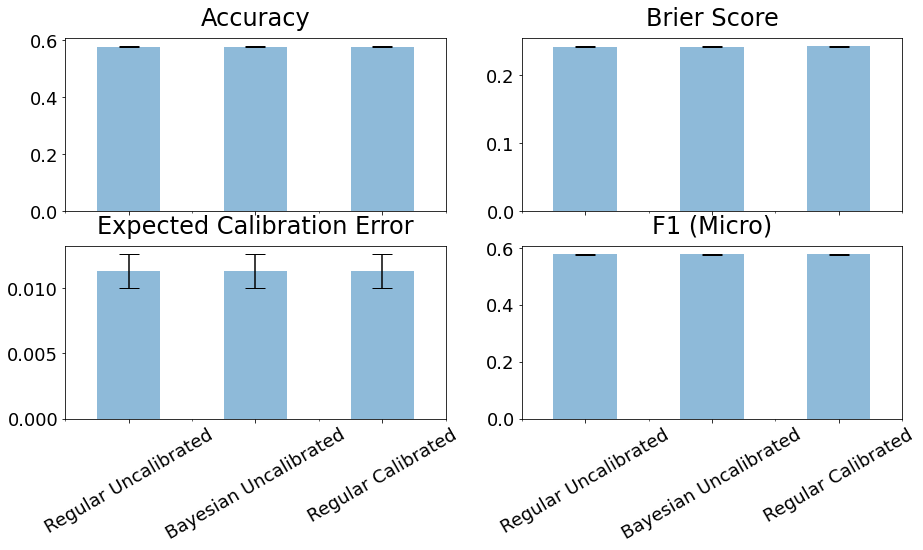

In [15]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 7), sharex=True)

for ax, score_name in zip(np.ravel(axarr), score_names):
    all_dfs = [df[score_name] for df in all_scores]
    plot_bar_chart_with_errors(all_dfs, ax=ax, title=score_name)

fig.show()